# BASELINE PREREQUISITES

### IMPORT LIBRARIES

##### CLASSIC LIBS

In [4]:
%%time
import os
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from random import sample

Wall time: 4.14 s


##### FEATURES ENGEENIRING LIBS

In [436]:
%%time
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

Wall time: 0 ns


### DEFINITIONS

#### GET DATA FROM TRAIN DATASET

def get_data(val_split = False, test_size = 0.3):
    '''This function returns the '''
    path = '../catchafish/data'
    batch_size = 100000
    
    dir_iterator = DirectoryIterator(directory = path, 
                                     image_data_generator = None, 
                                     target_size = (32, 32), 
                                     batch_size = batch_size,
                                     shuffle = True, 
                                     dtype = int)
    
    X = dir_iterator[0][0]
    y = dir_iterator.labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
    
    if val_split:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)
        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_data()

#### GET DATA AND START DATA AUGMENTATION

In [340]:
%%time
def get_data_test(val_split = False, val_size = 0.3, zca_whitening = False):
    path = '../catchafish/data_test'
    batch_size = 1500
    dir_iterator = DirectoryIterator(directory = path,
                                     image_data_generator = None,
                                     target_size = (128, 128),
                                     batch_size = batch_size,
                                     shuffle = False,
                                     dtype = int)
    X = dir_iterator[0][0] / 255
    y = dir_iterator.labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
    image_data_generator = ImageDataGenerator(zca_whitening = zca_whitening,
                                              rotation_range = 5,
                                              width_shift_range = 0.3,
                                              height_shift_range = 0.3,
                                              shear_range = 0.3,
                                              zoom_range = 0.3,
                                              horizontal_flip = True,
                                              fill_mode = 'nearest')
    if zca_whitening:
        image_data_generator.fit(X_train)

    extended_output = []
    for images in image_data_generator.flow(X_train, y_train, batch_size = batch_size):
        extended_output.append(images)
        if len(extended_output) == 5:
            break

    X_train = extended_output[0][0]
    y_train = extended_output[0][1]

    for data_tuple in extended_output[1:]:
        X_train = np.concatenate((X_train, data_tuple[0]), axis = 0)
        y_train = np.concatenate((y_train, data_tuple[1]), axis = 0)

    if val_split:
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
        return X_train, X_val, X_test, y_train, y_val, y_test
    else:
        return X_train, X_test, y_train, y_test

Wall time: 0 ns


In [341]:
%%time
X_train, X_test, y_train, y_test = get_data_test()

Found 1305 images belonging to 11 classes.


c:\users\dany\.venvs\lewagon\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Wall time: 19.2 s


In [342]:
%%time
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Wall time: 0 ns


((4565, 128, 128, 3), (392, 128, 128, 3), (4565,), (392,))

##### MAPPING

In [207]:
def names_mapping(key):
    fishes = { 0 : ("fish_01", "Dascyllus reticulatus"),
             1 : ("fish_02", "Plectroglyphidodon dickii"),
             2 : ("fish_03", "Chromis chrysura"),
             3 : ("fish_04", "Amphiprion clarkii"),
             4 : ("fish_05", "Chaetodon lunulatus"),
             5 : ("fish_07", "Myripristis kuntee"),
             6 : ("fish_08", "Acanthurus nigrofuscus"),
             7 : ("fish_09", "Hemigymnus fasciatus"),
             8 : ("fish_10", "Neoniphon sammara"),
             9 : ("fish_16", "Lutjanus fulvus"),
             10: ("fish_17", "Carassius auratus")}
    if len(key) == 1:
        return fishes[key]
    else: return [fishes[k] for k in key]

In [ ]:
fishs = names_mapping(y_test)
fishs

# HOGGING (IMAGE PREPROCESSING)

Wall time: 20.9 ms


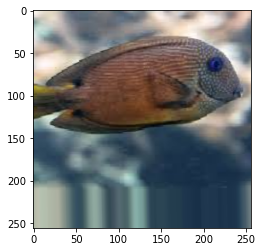

In [9]:
%%time
#reading the image
fish_key = 0
img = plt.imshow(X_train[fish_key])
resized_img = resize(X_train[fish_key], (256, 256))

In [10]:
%%time
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True, multichannel=True)

Wall time: 583 ms


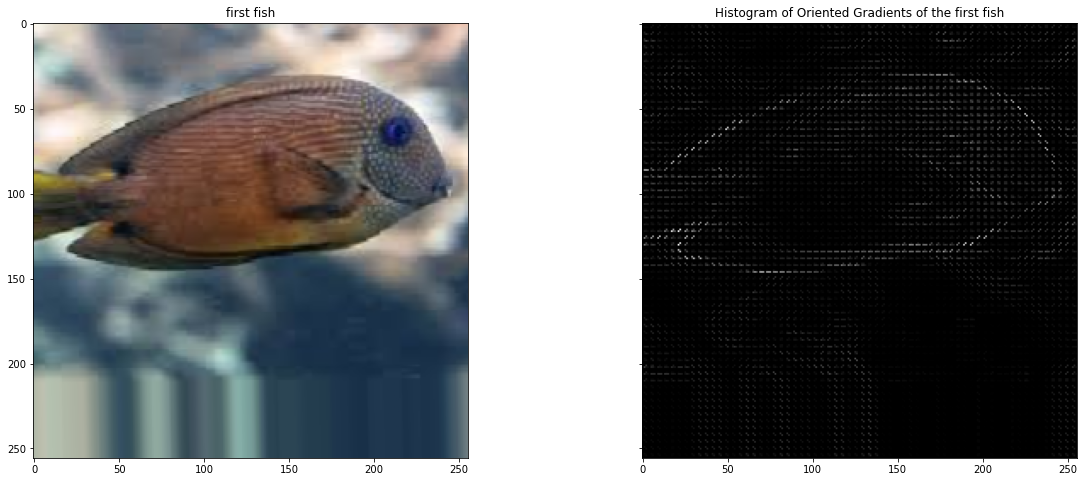

Wall time: 299 ms


In [11]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True) 

ax1.imshow(resized_img, cmap=plt.cm.gray) 
ax1.set_title('first fish') 

# Rescale for better display 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) 

ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray) 
ax2.set_title('Histogram of Oriented Gradients of the first fish')

plt.show()

### PREPARING THE DATASET WITH HOG PICTURES  

In [490]:
from IPython.display import Image

##### HOGGING DEFINITION

https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/?utm_source=blog&utm_medium=3-techniques-extract-features-from-image-data-machine-learning

The HOG descriptor focuses on the structure or the shape of an object, 
HOG is able to provide the edge direction as well.

Let us start with the simplest way to generate histograms. We will take each pixel value, find the orientation of the pixel and update the frequency table.

Here is the process for the highlighted pixel (85). Since the orientation for this pixel is 36, we will add a number against angle value 36, denoting the frequency:

hog_feature_steps


The same process is repeated for all the pixel values, and we end up with a frequency table that denotes angles and the occurrence of these angles in the image. This frequency table can be used to generate a histogram with angle values on the x-axis and the frequency on the y-axis.

In [25]:
def hogging_pictures(img, orientations=9):
    res_img = resize(img, (256, 256))
    fd, hog_image = hog(res_img, orientations = 9, 
                         pixels_per_cell=(4, 4), 
                         cells_per_block=(2, 2), 
                         visualize=True, 
                         multichannel=True)
    return hog_image

##### TEST SET GRAYSCALING

%%time
resized_img_test = []
for x in X_test:
    resized_img_test.append(resize(x, (256, 256))) 

resized_img_test = np.array(resized_img_test)

resized_img_test.shape

#### HOGGING TRAIN SET

In [38]:
%%time
hogged_train_set = []
for r in resized_img:
    hogged_train_set.append(hogging_pictures(r))

Wall time: 47min 19s


In [39]:
X_train_hogged = np.array(hogged_train_set)

In [40]:
X_train_hogged.shape

(4565, 256, 256)

#### HOGGING TEST SET

In [41]:
%%time
hogged_test_set = []
for r in resized_img_test:
    hogged_test_set.append(hogging_pictures(r))

Wall time: 4min 19s


In [42]:
X_test_hogged = np.array(hogged_test_set)

# IMAGE READING (OPENCV)

def loadImages(path):
    # Put files into lists and return them as one list of size 4
    image_files = [file for file in os.listdir(path) if  file.endswith('.jpg')]
    return image_files

In [314]:
subfolders = [ f.path for f in os.scandir('../catchafish/data_test/') if f.is_dir()]

In [315]:
subfolding = [next(os.walk(f'{s}')) for s in subfolders]

In [316]:
def get_subfolding(subfolding):
    path, dirs, files = subfolding 
    filenames = [ f'{path}/{f}' for f in files ]
    return filenames 

In [353]:
filenames_list = [get_subfolding(subfolding[i]) for i in range(len(subfolding))]

In [354]:
labels_count = [len(f) for f in filenames_list]
labels_count

[126, 122, 109, 129, 136, 129, 115, 128, 125, 102, 84]

##### CREATING LABELS aka Y_TRAIN

In [377]:
labels = []
for i in range(len(labels_count)):
    labels.append([int(i)] * labels_count[i])   
y_opencv = np.array([x for y in labels for x in y])

In [378]:
y_opencv.shape

(1305,)

In [355]:
filenames = [ x for y in filenames_list for x in y ] #FLATTENING

In [320]:
%%time
#imagespaths = [loadIma'ges(f) for f in subfolders]
im_data = [cv2.imread(f'{f}') for f in filenames]

Wall time: 9.66 s


In [321]:
im_data[0].shape

(487, 650, 3)

In [322]:
im_data_array = np.array(im_data)

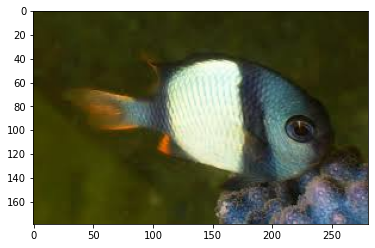

In [323]:
plt.imshow(im_data_array[54])

# IMAGE RESIZING

In [324]:
%%time
im_dimensions = (128, 128)
im_resized_data = []
for im in im_data:
    res = cv2.resize(im, im_dimensions, interpolation=cv2.INTER_LINEAR)
    im_resized_data.append(res)

Wall time: 123 ms


In [ ]:
%%time
#reading the image
fish_key = 0
img = plt.imshow(X_train[fish_key])
resized_img = resize(X_train[fish_key], (256, 256))

In [430]:
im_resized_data_array = np.array(im_resized_data)

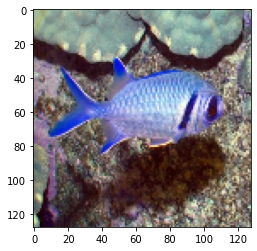

In [434]:
plt.imshow(im_resized_data_array[650])

# HOGGING (NO OPENCV)

In [474]:
%%time
hogged_data = []
for im in im_resized_data_array:
    fd, hog_image = hog( resize(im, (128, 128)), 
                        orientations = 6 , 
                        pixels_per_cell=(3, 3), 
                        cells_per_block=(2, 2), 
                        visualize=True, 
                        multichannel=True)
    hogged_data.append(hog_image)

Wall time: 4min 26s


In [501]:
hogged_data_array = np.array(hogged_data)

In [502]:
hogged_data_array.shape

(1305, 128, 128)

In [505]:
X_hogged_reshaped = np.reshape(hogged_data_array, (hogged_data_array.shape[0], hogged_data_array.shape[1] * hogged_data_array.shape[1]))

In [518]:
#PRINTING ORIENTATED GRADIENTS 

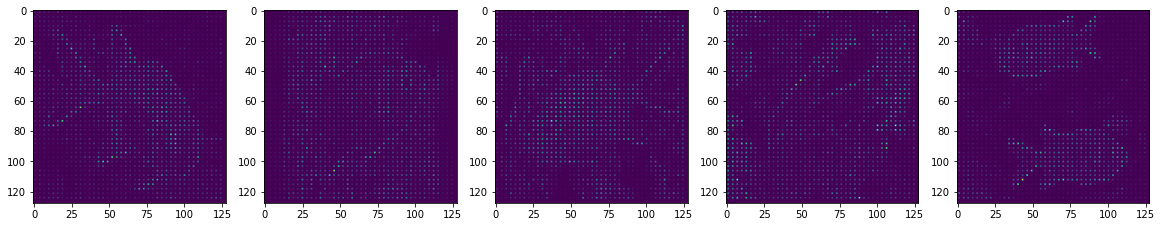

In [517]:
plt.figure(figsize=(20,4))
index = 630
for i, h in enumerate(hogged_data_array[index: index+5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(h)

In [405]:
bin_n = 16 # Number of bins
#affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def hog(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist

In [406]:
im_data_hogged = [hog(im) for im in im_resized_data ] 

In [407]:
X_opencv = np.array(im_data_hogged)

In [410]:
X_opencv.shape

(1305, 64)

import cv2 as cv
svm = cv.ml.SVM_create()
svm.setType(cv.ml.SVM_C_SVC)
svm.setKernel(cv.ml.SVM_RBF)
svm.setTermCriteria((cv.TERM_CRITERIA_MAX_ITER, 100, 1e-6))

svm.train(trainingData, cv.ml.ROW_SAMPLE, labels)

##### MODEL PARAMS

svm_params = dict( kernel_type = cv2.SVM_LINEAR,
                    svm_type = cv2.SVM_C_SVC,
                    C=2.67, gamma=5.383 )

##### TRAIN/TEST SPLIT 

In [506]:
X_train, X_test, y_train, y_test = train_test_split(X_hogged_reshaped , y_opencv, test_size = 0.3)

In [507]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((913, 16384), (392, 16384), (913,), (392,))

##### MODEL INSTANCING

In [509]:
hogged_svc = SVC(gamma='scale', kernel='rbf')

In [510]:
hogged_svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [511]:
hogged_svc.score(X_test, y_test)

0.461734693877551

# DENOISE (IMAGE PREPROCESSING)

In [422]:
%%time
# Remove noise w/ Gaussian blur
im_data_denoise = [(cv2.GaussianBlur(im_resized_data[im], (9, 9), cv2.BORDER_CONSTANT)) for im in range(len(im_resized_data))]

Wall time: 96.7 ms


# SEGMENTATION + MARKERS APPLICATION (IMAGE PREPROCESSING)

In [423]:
%%time
im_data_gray = [cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) for im in im_data_denoise]
im_data_segmented = [cv2.threshold(cv2.UMat(im), 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) for im in im_data_gray]

Wall time: 122 ms


In [426]:
img_array = cv2.UMat.get(im_data_segmented[650][1]) # cv2.UMAT TO ARRAY

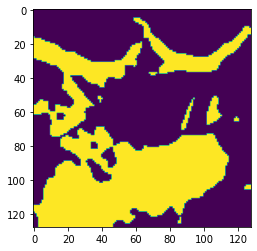

In [427]:
plt.imshow(img_array)

In [60]:
im_data_tresh = [im[1] for im in im_data_segmented]

In [73]:
# Further noise removal
kernel = np.ones((2, 2), np.uint8)
im_data_opening = [cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel, iterations=2) for im in im_data_tresh]

# sure background area
im_data_bg = [cv2.dilate(im, kernel, iterations=3) for im in im_data_opening]

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
#sure_fg = np.uint8(sure_fg)
#unknown = cv2.subtract(sure_bg, sure_fg)

#Displaying segmented back ground
#display(original, sure_bg, 'Original', 'Segmented Background')

# RESHAPING DATAS

### TRAIN/TEST SPLIT FROM GET DATA

X_train, X_test, y_train, y_test = get_data()

X, y = get_data_test()

X_test_2.shape, y_test_2.shape

### CHECK SHAPES

X_train.shape, y_train.shape, X_test.shape, y_test.shape

### RESHAPE X_TRAIN and X_TEST

In [44]:
X_train_reshaped = np.reshape(X_train_hogged, (X_train_hogged.shape[0], X_train_hogged.shape[1] * X_train_hogged.shape[1]))

In [45]:
X_test_reshaped = np.reshape(X_test_hogged, (X_test_hogged.shape[0], X_test_hogged.shape[1] * X_test_hogged.shape[1] ))

# BASELINE MODEL

### MODEL INSTANCING

In [20]:
logreg = LogisticRegression( C  = 0.01, n_jobs=-1, multi_class='multinomial', solver='lbfgs')

### MODEL FITTING

In [21]:
logreg.fit(X_train_reshaped, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### SCORE THE MODEL

In [22]:
logreg.score(X_test_reshaped, y_test)

0.43735105982691586

In [23]:
logreg.score(X_test_2_reshaped, y_test_2)

0.06719367588932806

In [23]:
y_predict = logreg.predict(X_test_reshaped)

### GET THE MISCLASSIFIED PICTURES

In [39]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, y_predict):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index += 1

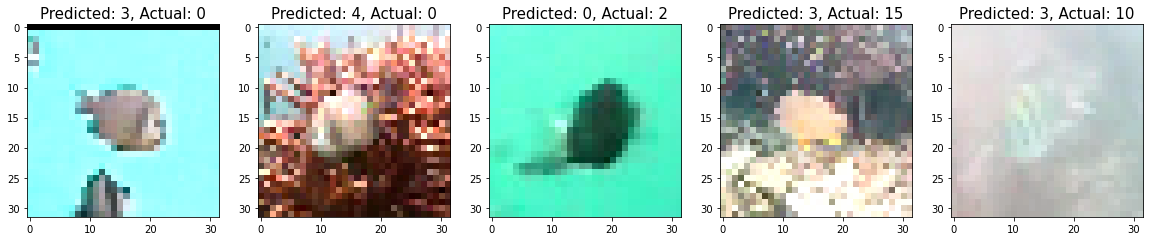

In [41]:
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(X_test_reshaped[badIndex], (32,32,3)))
    plt.title('Predicted: {}, Actual: {}'.format(y_predict[badIndex], y_test[badIndex]), fontsize = 15)

# FIRST STEPS ML MODEL == SVC

### TRAINING SVC MODEL

##### RBF

In [51]:
svc_model = SVC(gamma='scale', kernel='rbf')

In [52]:
%%time
svc_model.fit(X_train_reshaped, y_train)

Wall time: 34min 31s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
%%time
svc_model.score(X_test_reshaped, y_test)

Wall time: 1min 52s


0.26785714285714285

##### LINEAR

In [50]:
svc_model_l = SVC(gamma='scale', kernel='linear')

In [ ]:
svc_model_l.fit()

svcgrid.best_estimator_

svcgrid.best_score_

best_svc = svcgrid.best_estimator_

best_svc.score(X_test_scaled, y_test)

from sklearn.metrics import classification_report

y_pred = best_svc.predict(X_test_scaled)

fishnames = ["Dascyllus reticulatus",
             "Plectroglyphidodon dickii",
             "Chromis chrysura",
             "Amphiprion clarkii",
             "Chaetodon lunulatus",
             #"Chaetodon trifascialis",
             "Myripristis kuntee",
             "Acanthurus nigrofuscus",
             "Hemigymnus fasciatus",
             "Neoniphon sammara",
             "Lutjanus fulvus", 
             "Scolopsis bilineata"]

svc_report = classification_report(y_test, y_pred, target_names = fishnames)

### MISSCLASSIFIED PICTURES  OF FISH CATEGORIE 1

indexes = [i for i, y in enumerate(y_test) if y == 1]
missclassified_cat1 = [ y_pred[ind] for ind in indexes ]
plt.figure(figsize=(20, 4))
for i, j  in enumerate(indexes[5:10]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.reshape(X_test_reshaped[j], (32,32,3)))
    plt.title('Predicted: {}, Actual: {}'.format(y_pred[j], y_test[j]), fontsize = 15)

# NAIVES BAYES

In [54]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train_reshaped, y_train)

c:\users\dany\.venvs\lewagon\lib\site-packages\sklearn\model_selection\_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.23379175, 0.21710526, 0.2259552 ])

# SGD CLASSIFIER

In [ ]:
sgd_model = SGDClassifier(max_iter=1000)
cross_val_score(sgd_model, X_train_reshaped, y_train)

In [13]:
sgd_model = SGDClassifier(max_iter=1000)

In [14]:
sgd_param_grid = {"loss": ["hinge","log"], "penalty" : ["l2", "l1", "elasticnet"], "alpha" : [0.01, 0.001, 0.0001] }

In [15]:
sgd_gridsearch = GridSearchCV(estimator = sgd_model,
                              param_grid = sgd_param_grid, cv = 10,
                              n_jobs = -1,
                              scoring = 'accuracy',
                              verbose = True)

In [ ]:
sgd_gridsearch.fit(X_train_reshaped, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [215]:
sgd_gridsearch.best_score_

0.4971751412429379

In [218]:
sgd_gridsearch.best_estimator_

SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [216]:
sgd_best = sgd_gridsearch.best_estimator_

In [217]:
sgd_best.score(X_test_scaled, y_test)

0.35526315789473684

# KNN CLASSIFIER

In [ ]:
from sklean.neighbors import KNeighborsClassifier

In [ ]:
knn_model = KNeighborsClassifier(n_jobs=-1)

In [ ]:
knn_param_grid = {"n_neighbors" : [2, 5, 10, 15],
                  "p" : [1, 2], 
                  "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]}

In [ ]:
knn_gridsearch = GridSearchCV(estimator = knn_model,
                              param_grid = knn_param_grid, cv = 5,
                              n_jobs = -1,
                              scoring = 'accuracy',
                              verbose = 1)

In [ ]:
knn_report = classification_report(y_test, y_pred, target_names = fishnames)

# RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc_model = RandomForestClassifier(n_jobs=-1)

In [ ]:
rfc_param_grid = {"n_estimators": [100, 150, 250],
                  "max_depth": [2, 3, 4, 7],
                  "min_samples_split" : [2, 5, 10, 15]}

In [ ]:
rfc_gridsearch = GridSearchCV(estimator = rfc_model,
                              param_grid = rfc_param_grid, cv = 5,
                              n_jobs = -1,
                              scoring = 'accuracy',
                              verbose = 1)

In [ ]:
rfc_report = classification_report(y_test, y_pred, target_names = fishnames)

# APPLICATION : A FISH DETECTION PIPELINE

### SPECIFIC LIBRARIES

In [ ]:
from skimage import data, transform
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain

### DATA SET WITH FISH PRECENCE CONFIRMED

In [ ]:
%%time
X_fish_train, X_fish_test, y_fish_train, y_fish_test = get_data_test()

### DATA EXTRACTION TO GET NEGATIVE DATA SET

In [ ]:
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size) for patch in patches])
    return patches

In [ ]:
negative_patches = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])

### COMBINE SETS AND EXTRACT HOG 

In [ ]:
X_train = np.array([feature.hog(im) for im in chain(positive_patches,negative_patches)])
y_train = np.zeros(X_train.shape[0])

### TRAIN THE MODEL

f_svc_model = SVC(verbose= True)

In [ ]:
f_svc_param_grid = { 'C' : [2.0, 4.0, 8.0] }

In [ ]:
f_svc_gridcv = GridSearchCV(estimator = f_svc_model,
                           param_grid = f_svc_param_grid, cv = 5, 
                           n_jobs = -1, 
                           scoring = 'accuracy')